# Topic Modeling
### First attempt
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

In [1]:
# Importing modules
import gensim
import nltk
import os
import string
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [2]:
# Read data into papers
data = pd.read_csv('D:\\Alerta Backup Data\\gonzalo_data\\datasets\\text\\data_clean_large.csv', sep=';')
data = data.dropna(subset=['text'])
data = data[data['class'] == 0]
# Print head
data.head()

,class,text,image
0,0,© From your Google Drive Interview-Mode BK99 S...,focused_Algorithms_one_0.jpg
1,0,=] Computatior] ] + File Edit View Insert Form...,focused_Algorithms_one_1.jpg
2,0,= 401 Computational Geometry File Edit View ...,focused_Algorithms_one_10.jpg
3,0,= 401 Computational Geometry File Edit View ...,focused_Algorithms_one_100.jpg
4,0,= 401 Computational Geometry File Edit View ...,focused_Algorithms_one_101.jpg


In [71]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(["edit", "file", "view", "google", "tools", "help", "format", "insert", "tab", "bk", "ses", "es"])
stop_words.extend(['canvas', 'sion', 'oc', 'go', 'oe', 'drive', 'web', 'store', 'add', 'shortcut', 'gm', 'image', 'account', 'dashboard', 'calendar', 'commons', 'ie', 'assignments', 'adob', 'mec', 'hal', 'adi', 'je', 'alg', 'session', 'ra', 'eativ', 'ort', 'cmsc', 'cor', 'lecture', 'share', 'new', 'ee', 'due', 'monday', 'prr', 'none', 'next', 'pre', 'make', 'text', 'question', 'also', 'would', 'one', 'two', 'three', 'four', 'know', 'good', 'bad', 'get', 'normal', 'like', 'email', 'inbox', 'vcu', 'aa', 'notes', 'use', 'exam', 'may', 'us', 'oo', 'untitled', 'slide', 'part', 'work', 'search', 'na', 'ae', 'answer', 'solution', 'lc', 'arial', 'month', 'files', 'test' 'doc', 'day', 'cc', 'see', 'able', 'define', 'last', 'used', 'eb', 'pm', 'first', 'status', 'doc', 'home', 'must', 'many', 'things', 'dont', 'site', 'lc', 'el', 'edited', 'much', 'size'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
#Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of accents
    doc = doc.encode('ascii', 'ignore').decode('ascii')
    # Removal of whitespaces
    doc = " ".join(doc.split())
    # Lowercasing
    return doc.lower()

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [73]:
text = data.dropna(subset=['text']).text
words = list(sent_to_words([clean(doc) for doc in text]))
data_words = remove_stopwords(words)
print(data_words[:1][0][:30])

['interviewmode', 'computational', 'geometry', 'computational', 'geometry', 'signme', 'points']


In [74]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1)]


In [75]:
coherence = []
for k in range(3,20):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus, id2word=id2word, num_topics=k, passes=40,iterations=200, chunksize = 10000, eval_every = None)
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts, dictionary=id2word, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19


LDA requires specifying the number of topics. We can tune this through optimization of measures such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing a coherence measure, named Cv [1], leads to better human interpretability. We can test out a number of topics and asses the Cv measure: https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

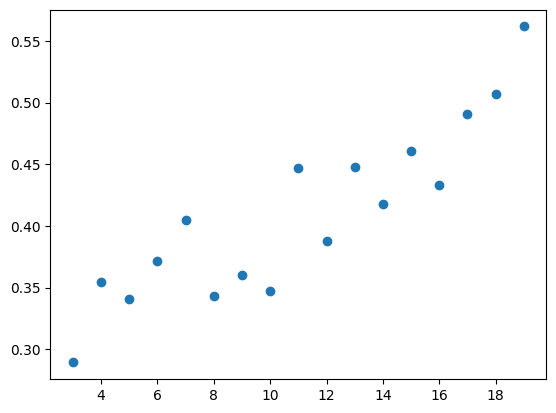

In [76]:
import matplotlib.pyplot as plt
plt.scatter(*zip(*coherence))
plt.show()

In [79]:
from pprint import pprint
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"team" + 0.003*"million" + 0.003*"members" + 0.003*"people" + '
  '0.002*"revenue" + 0.002*"video" + 0.002*"extensions" + 0.002*"information" '
  '+ 0.002*"zoom" + 0.002*"time"'),
 (1,
  '0.004*"correct" + 0.003*"attempts" + 0.003*"vectors" + 0.003*"extensions" + '
  '0.003*"course" + 0.003*"point" + 0.002*"ph" + 0.002*"people" + '
  '0.002*"vector" + 0.002*"average"'),
 (2,
  '0.005*"zoom" + 0.003*"extensions" + 0.003*"point" + 0.002*"numbers" + '
  '0.002*"structure" + 0.002*"people" + 0.002*"side" + 0.002*"case" + '
  '0.002*"control" + 0.002*"current"'),
 (3,
  '0.005*"design" + 0.003*"time" + 0.003*"people" + 0.003*"revenue" + '
  '0.003*"set" + 0.002*"million" + 0.002*"review" + 0.002*"extensions" + '
  '0.002*"edge" + 0.002*"black"'),
 (4,
  '0.003*"set" + 0.003*"people" + 0.003*"team" + 0.002*"edge" + 0.002*"points" '
  '+ 0.002*"convex" + 0.002*"equation" + 0.002*"extensions" + 0.002*"black" + '
  '0.002*"evidence"'),
 (5,
  '0.005*"people" + 0.003*"time" + 0.002

In [80]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = 'ldavis_prepared_'+str(num_topics)

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.016626 -0.027070       1        1  8.080233
16    -0.037049  0.031830       2        1  7.243836
17     0.040122  0.000537       3        1  6.867361
18     0.079297  0.027567       4        1  6.807773
14     0.006600 -0.013379       5        1  6.706953
15     0.006431 -0.045700       6        1  5.607789
1     -0.030297 -0.025450       7        1  5.446039
8     -0.007669 -0.000148       8        1  5.121348
12    -0.033163 -0.007404       9        1  4.976061
6     -0.024275  0.024095      10        1  4.962108
13    -0.019663  0.018528      11        1  4.926135
11    -0.011058 -0.026296      12        1  4.460591
5     -0.044821 -0.002389      13        1  4.340137
3      0.034402  0.023950      14        1  3.914769
0     -0.004890  0.011177      15        1  3.833411
10    -0.016392  0.066959      16        1  3.805909
9      0.020225 -0.009803      17        1  3.573601
7      0.020850 -0.039504      18        1  3.501523
4      0.020870 -0.022302      19        1  3.324460
2      0.017104  0.014803      20        1  2.499961, topic_info=              Term         Freq        Total Category  logprob  loglift
1115          edge  1749.000000  1749.000000  Default  30.0000  30.0000
2604          team  2195.000000  2195.000000  Default  29.0000  29.0000
642           zoom  3612.000000  3612.000000  Default  28.0000  28.0000
20443      vectors   948.000000   948.000000  Default  27.0000  27.0000
931        correct  1319.000000  1319.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
865         people    75.149828  4575.060070  Topic20  -6.2091  -0.4200
4303       million    57.229697  1692.843330  Topic20  -6.4815   0.3018
891    information    55.822455  1586.207651  Topic20  -6.5064   0.3420
1880         guest    58.544094  2472.261327  Topic20  -6.4588  -0.0542
3147      learning    54.912991  1940.902874  Topic20  -6.5229   0.1237

[1923 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
47906      1  0.048883    aaec
47906      2  0.244414    aaec
47906      4  0.048883    aaec
47906      5  0.488828    aaec
47906     12  0.048883    aaec
...      ...       ...     ...
642       18  0.039304    zoom
642       19  0.019098    zoom
642       20  0.056464    zoom
56704      5  0.649152  zoryan
56704      6  0.162288  zoryan

[13766 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 17, 18, 19, 15, 16, 2, 9, 13, 7, 14, 12, 6, 4, 1, 11, 10, 8, 5, 3])